In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  0
Num CPUs Available:  1


## Modele BERT

Ici, nous allons utiliser un modele BERT pour faire des predictions sur des textes. It's already trained.

## Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

In [109]:
import pandas as pd

# import csv
raw_data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Content
It contains the following 6 fields:
1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet
3. date: the date of the tweet
4. flag: The query. If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted
6. text: the text of the tweet

In [30]:
sample_size = 1000 # Number of tweets to use for this notebook

data = raw_data.sample(sample_size).copy(deep=True)
data['target'] = data['target'].map(lambda x: 1 if x == 4 else 0).astype('bool')
data['ids'] = data['ids'].astype('str')
data['date'] = data['date'].astype('str') # We will convert them to date if useful later, now we just want to reduce the size of the dataframe
data['flag'] = data['flag'].astype('str')
data['user'] = data['user'].astype('str')
data['text'] = data['text'].astype('str')

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from transformers import pipeline

def process_BERT_result_score(result):
    # print(result)

    final_score = None

    label = result[0]['label']

    # The result score goes from 0.5 to 1.0 and is labeled as POSITIVE or NEGATIVE. If the score is 0.5, it means that the model is not confident enough to make a decision.
    # We need a score that goes from 0 to 1.0 and 0 is sure it is negative and 1 is sure it is positive. 0.5 must be hard to predict.
    # If the prediction is labeled POSITIVE, we keep the score as it is.
    # If the prediction is labeled NEGATIVE, we need to scale the score from 0 to 0.5 with 0.5 being unsure if it really is negative.
    result_score = result[0]['score']

    if label == 'POSITIVE':
        final_score = result_score
    else:
        final_score = 1 - result_score
    
    # print(f"{label} : {final_score}")
    return final_score

def evaluate_roc_det(Y_test, Y_pred):
    # two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    ax_roc = axs[0]
    ax_det = axs[1]

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    DetCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_det)
    RocCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_roc)
    plt.gcf().set_facecolor('white')
    plt.show()
    

def evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = None):
    binary_pred = np.where(Y_pred > threshold, 1, 0)
    ConfusionMatrixDisplay.from_predictions(Y_test, binary_pred, ax=ax)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

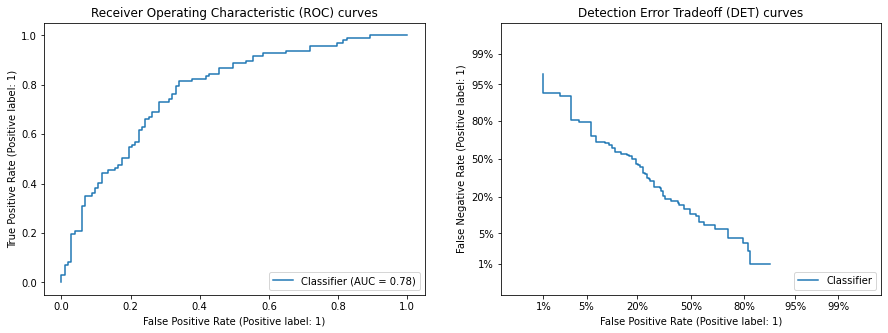

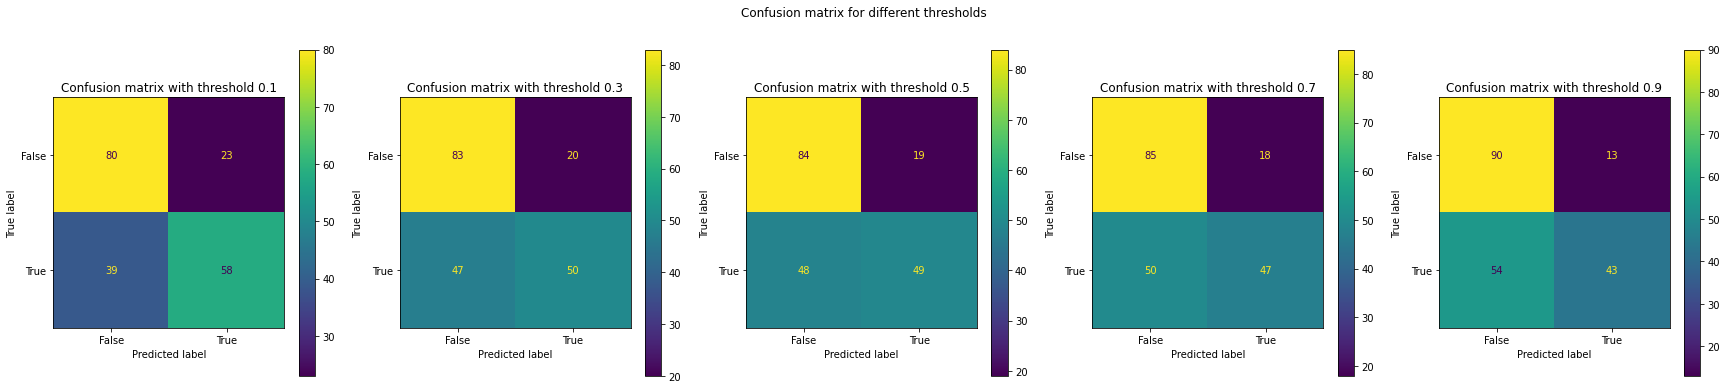

In [34]:
import numpy as np
from transformers import pipeline

distilbert_pipeline = pipeline("text-classification")

Y_pred = []
for i in range(len(X_test)):
    result = distilbert_pipeline(X_test.iloc[i])
    Y_pred.append(process_BERT_result_score(result))

evaluate_roc_det(Y_test, Y_pred)

possible_thresholds = np.linspace(0.1, 0.9, 5)
fig, axs = plt.subplots(1, len(possible_thresholds), figsize=(6*len(possible_thresholds), 6))
fig.suptitle("Confusion matrix for different thresholds")

for threshold, ax in zip(possible_thresholds, axs.ravel()):
    evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = ax)
    ax.set_title(f"Confusion matrix with threshold {round(threshold, 1)}")
plt.gcf().set_facecolor('white')
plt.show()

## Fine tuning

In [125]:
fine_tuning_data = raw_data.sample(300).copy(deep=True)
fine_tuning_data['label'] = fine_tuning_data['target'].map(lambda x: 1 if x == 4 else 0).astype('str')
fine_tuning_data = fine_tuning_data[['text', 'label']]

test_perc = 0.2
test_size = int(test_perc * len(fine_tuning_data))

test_data = fine_tuning_data.sample(test_size).copy(deep=True)
train_data = fine_tuning_data.drop(test_data.index)

In [126]:
# Importing the model
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_719', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [127]:
first_tweet = X_train.tolist()[0]
first_tweet_tokenized = tokenizer(first_tweet, return_tensors="tf", padding=True, truncation=True, return_token_type_ids=False, return_attention_mask=True)

print(first_tweet)
print('prediction:', model(first_tweet_tokenized)[0])

Tues 6:40am here,,, so time to hit the sack. Trust you all have a fantastic and inspiring Monday 
prediction: tf.Tensor([[-0.01655452 -0.10646194]], shape=(1, 2), dtype=float32)


In [138]:
from transformers import DataCollatorWithPadding
import datasets as Dataset


tok_train = train_data.apply(lambda x : tokenizer(x.tolist(), truncation=True), axis=0)
tok_test = test_data.apply(lambda x : tokenizer(x.tolist(), truncation=True), axis=0)


# from tokenized tweets to tf_dataset
X_train_ds = Dataset.from_pandas(tok_train)
X_test_ds = Dataset.from_pandas(tok_test)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")


tf_train_set = X_train_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = X_test_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

AttributeError: module 'datasets' has no attribute 'from_pandas'

In [104]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tf_train_set) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

model.compile(optimizer=optimizer)
model.fit(x = tf_train_set, epochs = 3)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


TypeError: in user code:

    File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\transformers\modeling_tf_utils.py", line 1398, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_file72txdcja.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_filef8kjp2od.py", line 16, in tf__call
        distilbert_output = ag__.converted_call(ag__.ld(self).distilbert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_file72txdcja.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_filetps0isi4.py", line 92, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (ag__.ld(input_ids),), dict(inputs_embeds=ag__.ld(inputs_embeds)), fscope)
    File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_fileje_iuk3y.py", line 32, in tf__call
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body, else_body, get_state, set_state, ('inputs_embeds',), 1)
    File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_fileje_iuk3y.py", line 27, in if_body
        inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)

    TypeError: Exception encountered when calling layer "tf_distil_bert_for_sequence_classification_31" (type TFDistilBertForSequenceClassification).
    
    in user code:
    
        File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\transformers\modeling_tf_utils.py", line 733, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 742, in call  *
            distilbert_output = self.distilbert(
        File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_file72txdcja.py", line 36, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_filetps0isi4.py", line 92, in tf__call
            embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (ag__.ld(input_ids),), dict(inputs_embeds=ag__.ld(inputs_embeds)), fscope)
        File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_fileje_iuk3y.py", line 32, in tf__call
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body, else_body, get_state, set_state, ('inputs_embeds',), 1)
        File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_fileje_iuk3y.py", line 27, in if_body
            inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
    
        TypeError: Exception encountered when calling layer "distilbert" (type TFDistilBertMainLayer).
        
        in user code:
        
            File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\transformers\modeling_tf_utils.py", line 733, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 400, in call  *
                embedding_output = self.embeddings(input_ids, inputs_embeds=inputs_embeds)  # (bs, seq_length, dim)
            File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_fileje_iuk3y.py", line 32, in tf__call
                ag__.if_stmt(ag__.ld(input_ids) is not None, if_body, else_body, get_state, set_state, ('inputs_embeds',), 1)
            File "C:\Users\augustin\AppData\Local\Temp\__autograph_generated_fileje_iuk3y.py", line 27, in if_body
                inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
        
            TypeError: Exception encountered when calling layer "embeddings" (type TFEmbeddings).
            
            in user code:
            
                File "c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 113, in call  *
                    inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
            
                TypeError: Value passed to parameter 'indices' has DataType string not in list of allowed values: int32, int64
            
            
            Call arguments received by layer "embeddings" (type TFEmbeddings):
              • input_ids=tf.Tensor(shape=(None, 1), dtype=string)
              • position_ids=None
              • inputs_embeds=None
              • training=True
        
        
        Call arguments received by layer "distilbert" (type TFDistilBertMainLayer):
          • self=tf.Tensor(shape=(None, 1), dtype=string)
          • input_ids=None
          • attention_mask=None
          • head_mask=None
          • inputs_embeds=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer "tf_distil_bert_for_sequence_classification_31" (type TFDistilBertForSequenceClassification):
      • self={'input_ids': 'tf.Tensor(shape=(None, 1), dtype=string)', 'labels': 'tf.Tensor(shape=(None, 1), dtype=uint8)'}
      • input_ids=None
      • attention_mask=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True
